# CS 190I Homework 3: Multi-class classification in pytorch
In this machine problem (MP), you will train a neural network to classify textual sequences. You will use `torch.nn` to implement a neural network and use `torch.autograd` to calculate the gradient and train your model.

## Basic classes and functions in Pytorch

### [torch.autograd](https://pytorch.org/docs/stable/autograd.html)

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions. To obtain gradients for a tensor via autograd from arbitrary scalar valued functions, you can simply set `requires_grad=True`. Then you can call `backward()` on any scalar that you want to calculate gradient of. The gradients will be accumulated in the `.grad` attribute. You can refer to [this tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) for more information.

For example, let's calculate $∇_\boldsymbol{x}||\boldsymbol{x}||^2$ and verify if it equals $2\boldsymbol{x}$.

In [1]:
# Include packages
import math
import torch
from torch import nn
import random
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
%matplotlib inline

In [2]:
x = torch.randn(5, requires_grad=True)
norm_square = (x**2).sum()

# calculate gradient
norm_square.backward()

print(f"2x is: {2 * x.data}")
print(f"gradient is: {x.grad}")

2x is: tensor([ 0.2777, -1.5482, -1.6511,  3.1557,  1.0728])
gradient is: tensor([ 0.2777, -1.5482, -1.6511,  3.1557,  1.0728])


**Note:** the gradient is accumulated in the `.grad` attribute, so you need to clear the accumulated gradients before every iteration.

### [torch.nn](https://pytorch.org/docs/stable/nn.html#)
The `torch.nn` package defines a set of Modules, including all kinds of layers you might use in a neural network, loss functions, weight initialization functions, etc. In this notebook, we will introduce the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) in `torch.nn`, which define a set of functions you might use for various problems such as regression and classification.

For example, the following cell illustrates the use of `nn.MSELoss` to calculate the mean squared error.

In [3]:
x = torch.randn(5)
y = torch.randn(5)

# calculate MSE with torch
mse_th = ((x - y)**2).mean()
print(f"MSE using tensor operations: {mse_th}")

# calculate MSE with nn.MESLoss
loss_func = nn.MSELoss()
mse_nn = loss_func(x, y)
print(f"MSE using nn: {mse_nn}")

MSE using tensor operations: 1.158928632736206
MSE using nn: 1.158928632736206


### [torch.optim](https://pytorch.org/docs/stable/optim.html)
In previous homeworks, you manually update the parameters after calcuting the gradients. In fact, `torch.optim` implements various optimization algorithms such as SGD, which you can use to conveniently update your parameters. To do that, you simply need to create an optimizer (e.g., `torch.optim.SGD`) by specifying the parameters that need to be updated and associated optimization hyperparameters such as learning rate. In the training loop, you will need to modify your code to include the following two steps:
- Use `optimizer.zero_grad()` to clear gradients of parameters.
- Use `optimizer.step()` to automatically update parameters.

You can refer to [this tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) for more details and examples.

## Homework: Text Classification with Pytorch

In this problem, you will create a text-classification model thtat classifys whether a given movie review is positive or negative. We experiment with the dataset called [SST-2](https://nlp.stanford.edu/sentiment/).


**Download SST-2 dataset**

We provide you with the utility function that downloads and extracts document strings from raw SST-2 dataset.

In [4]:
import random
import requests
import zipfile
import csv

def download_and_extract(url, local_filename, extract_dir):
    try:
        # Download the file
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"Failed to download {url}. Status code: {response.status_code}")
        # Save to local file
        with open(local_filename, 'wb') as file:
            file.write(response.content)
        # Extract the file
        with zipfile.ZipFile(local_filename, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted {local_filename} to {extract_dir} successfully.")
    except Exception as e:
        print(f"Error: {e}")

def read_sst2(path, maxidx=None):
    data = {'documents' : [], 'labels' : []}
    with open(path, newline="", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile, delimiter="\t")
        for i, row in enumerate(reader):
            text = row["sentence"]
            label = int(row["label"])  # Convert the label to an integer (0 or 1)
            data['documents'].append(text)
            data['labels'].append(label)

            if i == maxidx:
                break
    print("Loaded ", len(data['documents']), " sample from ", path)
    return data

SST2_URL = "https://dl.fbaipublicfiles.com/glue/data/SST-2.zip"
download_and_extract(SST2_URL, 'sst2.zip', '.')
sst2_train = read_sst2("SST-2/train.tsv", )
sst2_dev = read_sst2("SST-2/dev.tsv", )
for _ in range(3):
    idx = random.randint(0, len(sst2_train['documents']))
    print(f"Example {idx}: {sst2_train['documents'][idx]}\tLabel: {sst2_train['labels'][idx]}")

Extracted sst2.zip to . successfully.
Loaded  67349  sample from  SST-2/train.tsv
Loaded  872  sample from  SST-2/dev.tsv
Example 960: its story about a young chinese woman , ah na , who has come to new york city to replace past tragedy with the american dream 	Label: 1
Example 59154: more tiring than anything . 	Label: 0
Example 15352: very little story or character 	Label: 0


Similar to the classification on MNIST where we convert raw images into raw image features. We first need to convert the raw movie review string into a common text feature: [**bag-of-words**](https://www.wikiwand.com/en/Bag-of-words_model).


**Tokenize**

In natural language processing, we always first split the full text into small pieces, i.e., tokens. This process is called **tokenize**, which helps us construct a sequence of integers to represent the text.

Below, you need to implement one basic tokenize function on the *documents*, that splits document string into a list of words and convert each word into corresponding integer index that represents the word.

More specifically, you need to implement following functions (details in the following cell):

**normalize(document)**: a function that lowercases all characters in the document and adds whitespace before and after ".,!?:;" characters.

**build_vocab(documents)**: a function that finds all unique words in the documents and creates a dictionary mapping from word to integer index in the vocabulary. Remember to add a special **\<unk\>** token into vocaboluary.

**tokenize(vocab2id, document)**: a function that first split document into a sequence of words and then convert words into corresponding indices in the vocabulary. For unkown words, use the index of **\<unk\>**.

**bag_of_words(vocab2id, documents)**: a function that constructs **bag-of-words** feature of documents. Bag of words is represented as a unordered collection of words.

In [5]:
documents = [
    "This is, the first document.",
    "This document , is the second document.",
    "And this is the third one.",
    "Is this the first document?",
    "How many documents are here"
]

In [6]:
import numpy as np
from collections import Counter
import re

def normalize(document):
    ## TODO:
    ## 1. Lowercase all characters in the document.
    ## 2. Add white space before and after following punctuation marks .,!?;:
    document = document.lower()
    document = re.sub(r'([.,!?;:])', r' \1 ', document)
    ## END OF YOUR CODE
    return document

def build_vocab(documents):
    # Build vocabulary
    vocabulary = set()

    for document in documents:
        ## TODO: normalize document, split the document into words and find the unique words
        document = normalize(document)
        vocabulary.update(document.split())
        ## END OF YOUR CODE

    vocabulary = sorted(list(vocabulary))
    assert "<unk>" not in vocabulary

    ## TODO: insert the <unk> token into the vocabulary
    vocabulary.insert(0, "<unk>")
    # vocabulary.insert(0, "<pad>")
    ## END OF YOUR CODE

    word2id = {} # A dictionary that maps from word to integer index in the vocabulary
    ## TODO: construct a mapping from word string into an integer index
    for i, word in enumerate(vocabulary):
        word2id[word] = i
    ## END OF YOUR CODE

    print("Number of unique words: ", len(vocabulary))
    print("The words are", vocabulary)
    print("Word to id dict is: ", word2id)
    return vocabulary, word2id

def tokenize(word2id, document):
    wordids = []
    ## TODO: Tokenize the document string into a list of integers called wordids
    document = normalize(document)
    for word in document.split():
        wordids.append(word2id.get(word, word2id["<unk>"]))
    # while len(wordids) < 53:
    #       wordids.append(word2id["<pad>"])
    ## END OF YOUR CODE
    return wordids

def bag_of_words_doc(word2id, document):
    feature = None
    ## TODO: Construct bag of word feature for a document
    feature = [0] * len(word2id)
    for i in tokenize(word2id, document):
        feature[i] += 1
    ## END OF YOUR CODE
    return feature

vocab, word2id = build_vocab(documents)
document = documents[0]
print("Input document: ", document)
print("Tokenize result: ", tokenize(word2id, document))
print("Document bag of words feature: ", bag_of_words_doc(word2id, document))

Number of unique words:  18
The words are ['<unk>', ',', '.', '?', 'and', 'are', 'document', 'documents', 'first', 'here', 'how', 'is', 'many', 'one', 'second', 'the', 'third', 'this']
Word to id dict is:  {'<unk>': 0, ',': 1, '.': 2, '?': 3, 'and': 4, 'are': 5, 'document': 6, 'documents': 7, 'first': 8, 'here': 9, 'how': 10, 'is': 11, 'many': 12, 'one': 13, 'second': 14, 'the': 15, 'third': 16, 'this': 17}
Input document:  This is, the first document.
Tokenize result:  [17, 11, 1, 15, 8, 6, 2]
Document bag of words feature:  [0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]


Now create a vocabulary using the entire SST-2 training set.

In [7]:
vocab, word2id = build_vocab(sst2_train['documents'])

Number of unique words:  14775
The words are ['<unk>', '!', '#', '$', '&', "'", "''", "'30s", "'40s", "'50s", "'53", "'60s", "'70s", "'80s", "'90s", "'d", "'em", "'ll", "'m", "'n", "'n'", "'re", "'s", "'til", "'ve", '(', ')', '*', '***', '****', '+', ',', '-', '--', '.', '/', '000', '1', '1/2', '10', '10-course', '10-year', '10-year-old', '100', '100-minute', '101', '103-minute', '105', '10th', '10th-grade', '11', '110', '112-minute', '12-year-old', '120', '127', '129-minute', '12th', '13', '13th', '14-year-old', '140', '146', '15', '15-year', '15th', '163', '168-minute', '170', '1790', '18', '18-year-old', '1899', '19', '1920', '1930s', '1933', '1937', '1938', '1940s', '1950', '1950s', '1952', '1957', '1958', '1959', '1960', '1960s', '1962', '1970', '1970s', '1972', '1973', '1975', '1979', '1980', '1980s', '1984', '1986', '1987', '1989', '1993', '1994', '1995', '1997', '1998', '1999', '19th', '19th-century', '2', '2-day', '2/3', '20', '20-car', '2000', '2001', '2002', '20th', '21/2', 

**Train MLP on SST2**

Implement a two-layer MLP with ReLU activation function for the binary classification task on SST-2. Use Cross Entropy loss (or equivalently negative loglikelihood) to train the model. Complete the `train_mlp_sst()` function to train your model, visualize the training losses and validation loss, and report the accuracy on validation set. Remember to tokenize the data on the fly during training to save memory.

In [8]:
class MyDataset(Dataset):
    def __init__(self, documents, labels, word2id):
        super().__init__()
        self.documents = documents
        self.labels = labels
        self.word2id = word2id
    def __len__(self):
        return len(self.documents)
    def __getitem__(self, index):
        tokenized_document = bag_of_words_doc(self.word2id, self.documents[index])
        tokenized_document = torch.tensor(tokenized_document).float()
        class_id = self.labels[index]
        class_id = torch.tensor(class_id).long()
        return tokenized_document, class_id

In [9]:
class TwoLayerMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        '''
        Create a two-layer fully-connected network
        Inputs:
        input_dim: dimension of input features
        hidden_dim: dimension of hidden layer
        output_dim: dimension of output
        '''
        super().__init__()
        ## TODO: define layers in the model
        ## Model architecture: input --> hidden layer --> output
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim, bias = True)
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim, bias = True)
        ## End of your code

    def forward(self, x):
        logits = None
        ## TODO: forward pass
        hiddens = self.linear1(x)
        act_hiddens = torch.nn.functional.relu(hiddens)
        logits = self.linear2(act_hiddens)
        ## End of your code
        return logits

In [10]:
def visualize_loss_acc(losses, accs, split):
    '''
    This function plots the loss curve and accuracy curve using matplotlib.
    '''
    # move tensors if cpu if needed
    losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in losses]
    accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in accs]

    # use matplotlib plot train curves
    plt.figure(figsize=(6, 10))
    plt.subplot(2, 1, 1)

    plt.plot(range(len(losses)), losses)
    plt.xlabel('Iter #')
    plt.ylabel('Loss')
    plt.title(f'{split} loss vs iteration number')

    plt.subplot(2, 1, 2)
    plt.plot(range(len(accs)), accs)
    plt.xlabel('Iter #')
    plt.ylabel('Acc')
    plt.title(f'{split} accuracy vs iteration number')

    # Show the figure.
    plt.show()

In [11]:
#dataset = MyDataset(sst2_train['documents'], sst2_train['labels'], word2id)
#dataloader = DataLoader(dataset = dataset, batch_size = 16, shuffle = True, collate_fn = None)

In [12]:
#for batch in dataloader:
#    print(batch)
#    break

In [13]:
def train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    '''
    This function trains the model using stochastic gradient desent on the dataset.
    Returns:
    model: the optimized model.
    '''

    losses = []
    accs = []
    val_losses = []
    val_accs = []

    ## TODO: define loss function and optimizer, use SGD optimizer
    dataset = MyDataset(sst2_train['documents'], sst2_train['labels'], word2id)

    val_features = [bag_of_words_doc(word2id, document) for document in sst2_val['documents']]
    val_targets = sst2_val['labels']
    val_features = torch.tensor(val_features).float().to(device)
    val_targets = torch.tensor(val_targets).long().to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    ## End of your code

    # Train loop
    # If implemented correctly, it should take <15 seconds for an epoch
    for i in tqdm(range(num_epochs)):
        ## TODO: shuffle training data
        model.train()
        dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, collate_fn = None)
        epoch_loss, epoch_acc = 0, 0
        ## End of your code

        for j, batch in enumerate(dataloader):
            ## TODO: get features and labels for the batch: dynamically convert raw document string into feature tensors
            ## TODO: calculate loss and gradient
            ## TODO: update parameters
            ## Note: remember to clear gradients before every iteration
            train_features, train_targets = batch
            train_features = train_features.to(device)
            train_targets = train_targets.to(device)

            logits = model(train_features)
            #probs = torch.nn.functional.softmax(logits, dim = -1)
            loss = loss_fn(logits, train_targets)

            epoch_loss += loss.item()
            epoch_acc += (logits.argmax(dim = -1) == train_targets).float().mean().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ## End of your code

        ## TODO: calculate loss, predictions, and accuracy
        model.eval()
        with torch.no_grad():
            logits = model(val_features)
            #probs = torch.nn.functional.softmax(logits, dim = -1)
            val_loss = loss_fn(logits, val_targets)
            val_acc = (logits.argmax(dim = -1) == val_targets).float().mean().item()


        ## Remember to wrap the computaions in torch.no_grad so that no computation graph is built
        ## End of your code
        losses.append(epoch_loss / len(dataloader))
        accs.append(epoch_acc / len(dataloader))
        val_losses.append(val_loss.item())
        val_accs.append(val_acc)

    print("Training done")
    visualize_loss_acc(losses, accs, "Training")
    visualize_loss_acc(val_losses, val_accs, "Validation")
    return model

  0%|          | 0/10 [00:00<?, ?it/s]

Training done


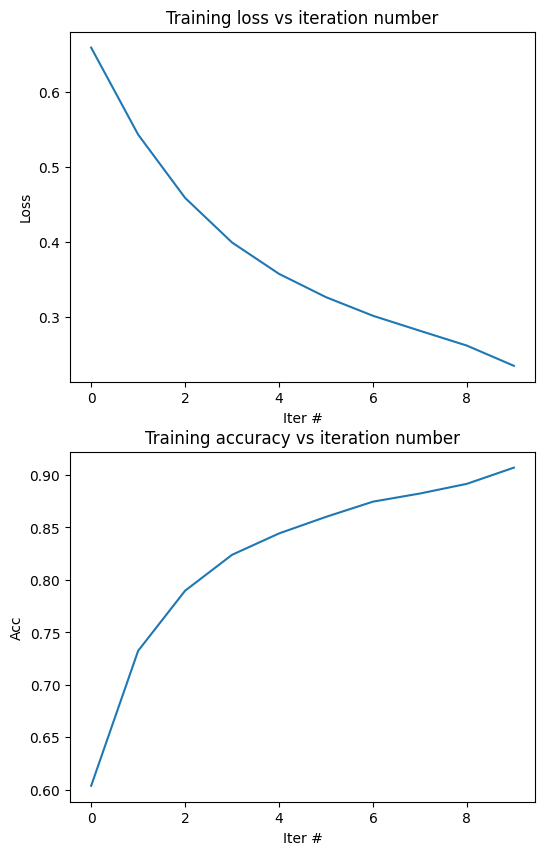

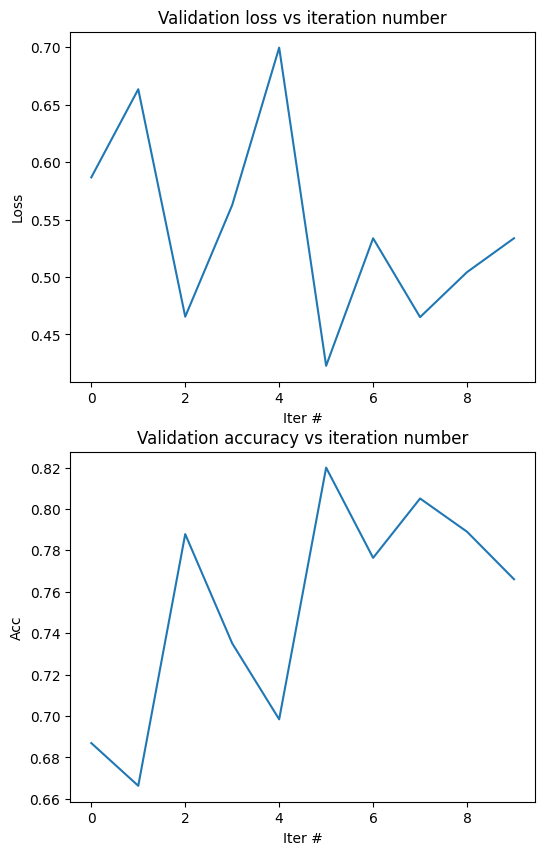

In [14]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.2
hidden_dim = 128 # use this as hidden layer dimension

model = None
#################################
## TODO: initialize model      ##
#################################
model = TwoLayerMLP(len(word2id), hidden_dim, 2)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

**Effect of number of layers**

Experiment with different hyper-parameters: try number of layers with 3, 5, 10. You need to implement a new model class called `NLayerMLP` that takes the number of layers as hyper-parameter and constructs an MLP with multiple layers.

Visualize the training loss and validation loss (visualize validation loss at the end of each epoch), discuss your findings

In [15]:
class NLayerMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, num_layers: int):
        '''
        Create a N-layer fully-connect network
        Inputs:
        input_dim: dimension of input features
        hidden_dim: dimension of hidden layer
        output_dim: dimension of output
        num_layers: number of hidden layers
        '''
        super().__init__()
        ## TODO: define layers in the model
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim, bias = True)
        self.hidden = torch.nn.Linear(hidden_dim, hidden_dim, bias = True)
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim, bias = True)
        ## End of your code

    def forward(self, x):
        logits = None
        ## TODO: forward pass
        hiddens = self.linear1(x)
        act_hiddens = torch.nn.functional.relu(hiddens)
        for _ in range(num_layers - 2):
            hiddens = self.hidden(act_hiddens)
            act_hiddens = torch.nn.functional.relu(hiddens)
        logits = self.linear2(act_hiddens)
        ## End of your code
        return logits

  0%|          | 0/10 [00:00<?, ?it/s]

Training done


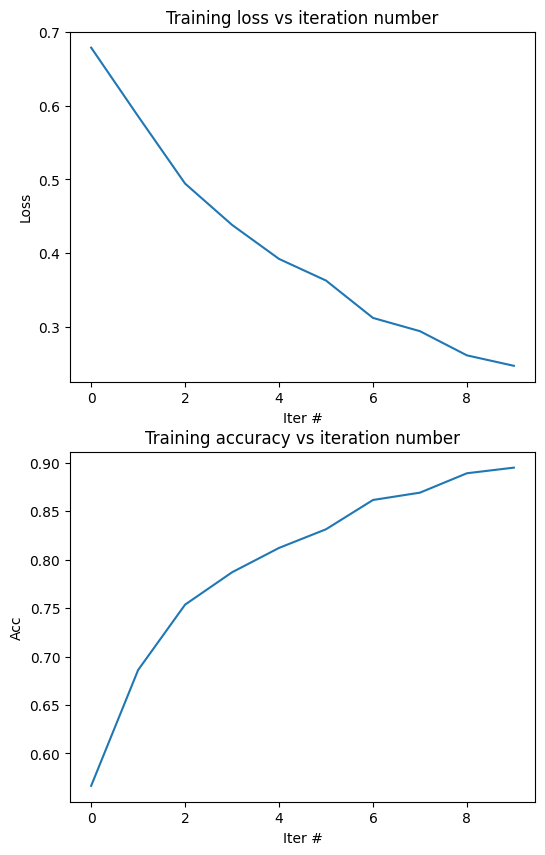

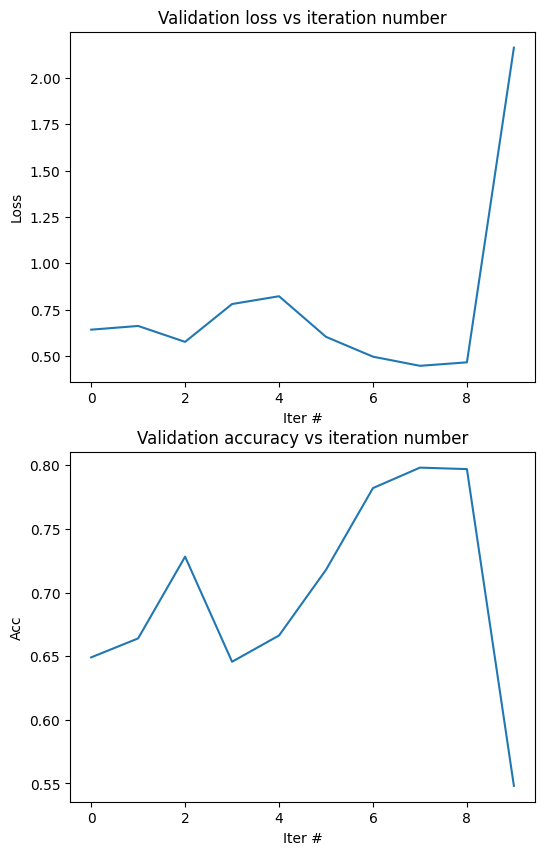

In [16]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.2
hidden_dim = 128 # use this as hidden layer dimension
num_layers = 3

model = None
#################################
## TODO: initialize model      ##
#################################
model = NLayerMLP(len(word2id), hidden_dim, 2, num_layers)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

  0%|          | 0/10 [00:00<?, ?it/s]

Training done


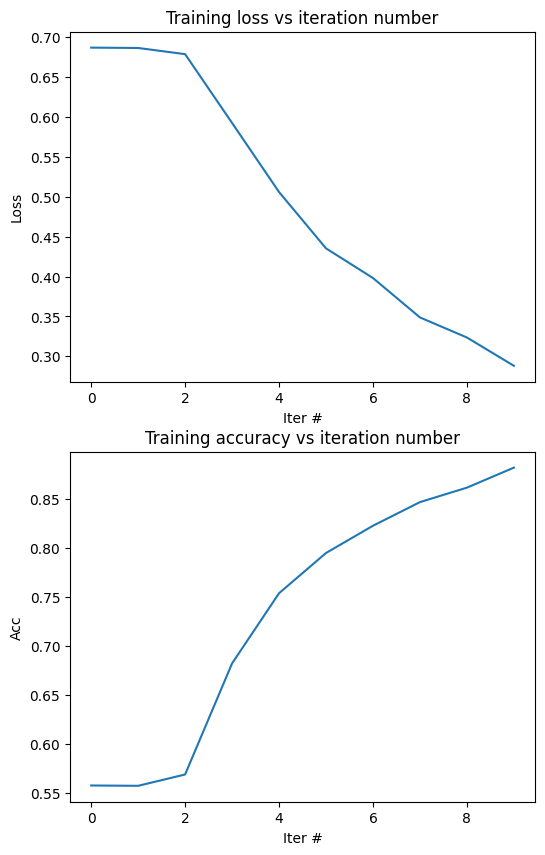

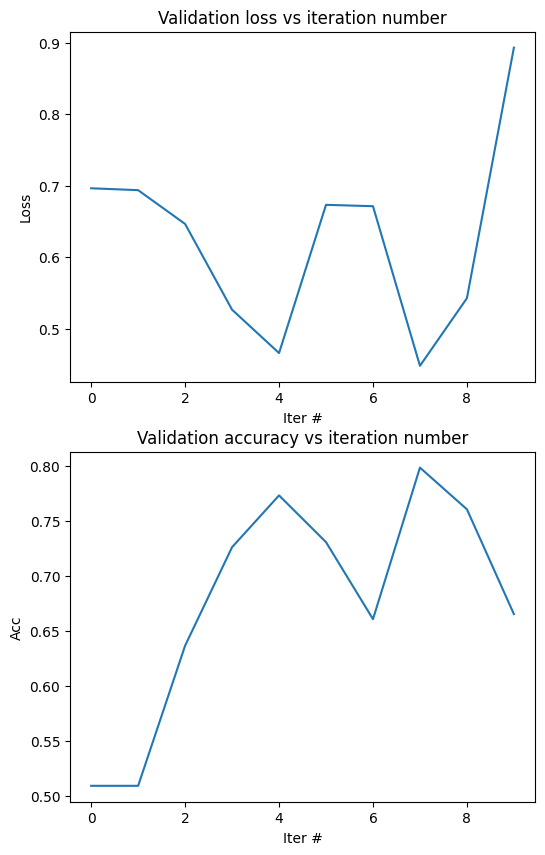

In [17]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.2
hidden_dim = 128 # use this as hidden layer dimension
num_layers = 5

model = None
#################################
## TODO: initialize model      ##
#################################
model = NLayerMLP(len(word2id), hidden_dim, 2, num_layers)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

  0%|          | 0/10 [00:00<?, ?it/s]

Training done


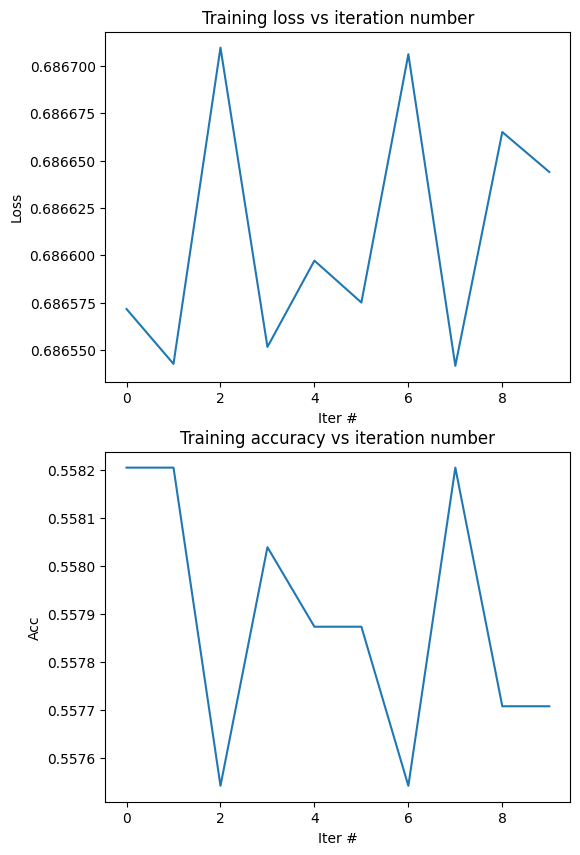

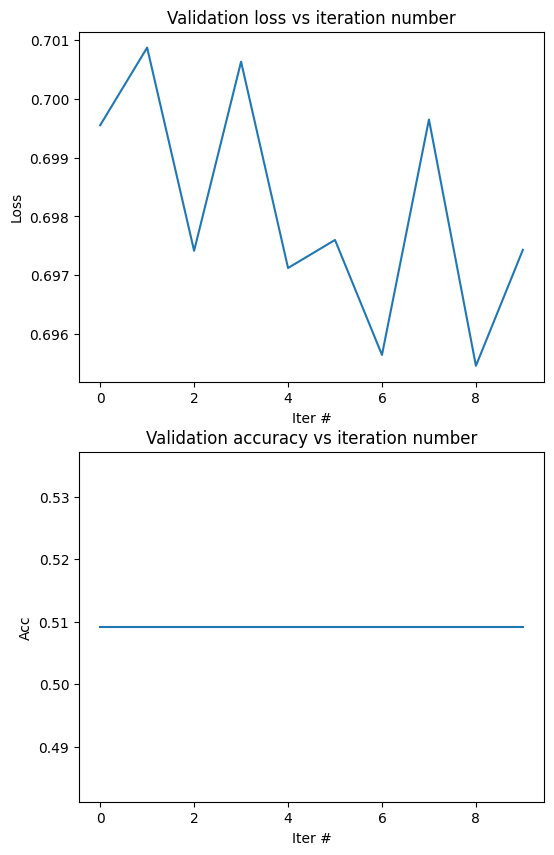

In [18]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 256
lr = 0.2
hidden_dim = 128 # use this as hidden layer dimension
num_layers = 10

model = None
#################################
## TODO: initialize model      ##
#################################
model = NLayerMLP(len(word2id), hidden_dim, 2, num_layers)
##################################
######### End of your code #######
##################################
model = train_mlp_sst(num_epochs, batch_size, lr, model, sst2_train, sst2_dev)

It seems that 5 hidden layers produced the best results. This may be due to 3 layers being not deep enough to capture the 14000 features while 10 layers is overfitting the data.